# Plots for South America

- Maps: Cut to latin america (without cono sur) (3*4 plots)
- Plot: 
    - LMR and iCESM prior (highest resolution) for Temperature and Precipitation (Infiltration in den Appendix)
    - Monsoon Index (specific region) -> Precipitation and temperature (iCESM, multi-model-ensemble (upsampled), LMR and also PHYDA for temperature)

In [47]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import wrapper
import dataloader
import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  
from matplotlib.offsetbox import AnchoredText    
import utils
import copy
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
array=np.random.randn(6300)

In [78]:
np.mean(np.mean(array)-array)

1.2406301735493813e-17

In [79]:
bu=np.mean(array)-array

In [80]:
np.mean(bu)

1.2406301735493813e-17

In [48]:
def anomaly(ds,start='1800',end='1850'):
    """
    start='1850'
    end='1900'
    """
    ds=ds-ds.sel(time=slice(start,end)).mean('time')
    return ds

def quick_filt(ts,cutoff=1/30):
    from scipy.signal import butter, lfilter, filtfilt
    def butter_lowpass(cutoff, fs, order=6, kf=1.2):
        # kf:  scaling factor for the lowpass frequency; 1 = Nyquist, 1.2 =
        #' 1.2xNyquist is a tradeoff between reducing variance loss and keeping
        #' aliasing small
        #fs is basic timestep (min_ts)
        #nyquist frequency
        nyq = 0.5 * fs 
        normal_cutoff = cutoff / nyq * kf
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a
    def butter_lowpass_filter(data, cutoff, fs, order=6):
        #filtfilt does not introduce a time-lag in comparison to butterworth 
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        #y = lfilter(b, a, data)
        return y
    return butter_lowpass_filter(ts,cutoff,fs=1,order=4)

In [49]:
#reference data

lmr_prec='/home/mchoblet/validation_data/prate_MCruns_ensemble_mean_LMRv2.1.nc'
lmr_prec=xr.open_dataset(lmr_prec).mean('MCrun')['prate']

LMR_tsurf_m='/home/mchoblet/validation_data/air_MCruns_ensemble_mean_LMRv2.1.nc'
lmr_tsurf=xr.open_dataset(LMR_tsurf_m).mean('MCrun')['air']

phyda_path='/home/mchoblet/validation_data/phyda.nc'
phyda=xr.open_dataset(phyda_path)
time_lmr=lmr_tsurf['time']
time_phyda=time_lmr[1:]
phyda['time']=time_phyda
phyda_tsurf=phyda['tas_mn']

#convert lmr_prec from kg/m²s to mm/month
lmr_prec=lmr_prec*24*60*60*30

In [50]:
#regions

bounds_europe=[[30,85],[310,50]]
bounds_global=[[-90,90],[0,360]]
bounds_sa=[[-57.5,15],[270,330]]
bounds_america=[[-60,30],[240,330]]
monsoon_region=[[-17.5,-5],[287.5,312.5]] #Vuille 2012

In [72]:
def regionalmean(field,lats,lons,name=None):
    """
    Function that calculates the regional mean of a climate field. (Eg nino index if you have SST data).
    Does latitudinal weight averageing. Also computes correct average for cross zero meridan regions (e.g 350,10)

    Input:
        - Climate Field (time,lat,lon): GMT computed over lat,lon for given restructions
        - lat =[latSouth,latNorth], lon =[latWest,lonWest] Limits of the Region of interest.
        Given in -90 to 90 and 0 to 360 degrees.
        - variable name

    Maybe in the future: Non-rectangular regions (there I would need to explicitely specify all the gridpoints I guess)
    """
    lat=field.lat
    lon=field.lon
    
    #selection of longitudes
    if lons[0]<lons[1]:
        #import pdb
        #pdb.set_trace()
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    #cross zero-meridian region option
    else:
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    
    wgt=np.cos(np.deg2rad(lat))
    field_m=field.sel(lat=sel_lat,lon=sel_lon).weighted(wgt).mean(('lat','lon'))
    if name!=None:
        field_m=field_m.rename(('regm_'+name))
    return field_m


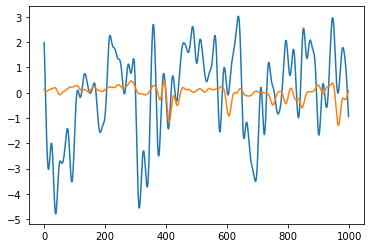

In [31]:
plt.plot(model_mean_prec)
plt.plot(model_mean_prec_glb)

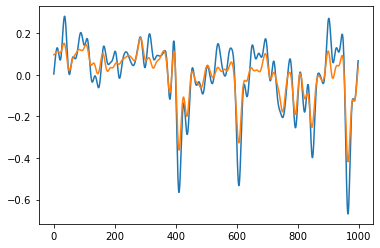

In [32]:
plt.plot(model_mean_temp)
plt.plot(model_mean_temp_glb)

Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


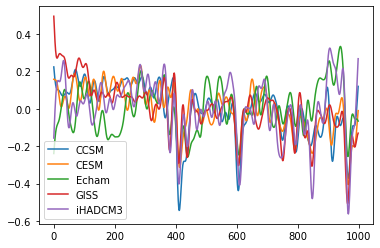

Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


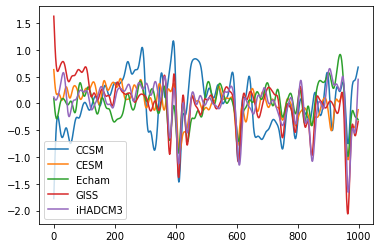

In [38]:
model_data2=[]
for m,p in models_tsurf.items():
    data=dataloader.annual_mean(xr.open_dataset(p)['tsurf'],check_nan=True).sel(time=slice('0851','1849'))
    data=quick_filt(utils.globalmean(anomaly(data,start=start_a,end=end_a)),cutoff=cutoff)
    plt.plot(data,label=m)
    model_data2.append(data)
    
model_mean_temp_glb=np.median(model_data2,axis=0)
model_std_temp_glb=np.std(model_data2,axis=0)

plt.legend()
plt.show()

model_data2=[]
for m,p in models_prec.items():
    data0=dataloader.annual_mean(xr.open_dataset(p)['prec'],check_nan=True).sel(time=slice('0851','1849'))
    data=quick_filt(utils.globalmean(anomaly(data0,start=start_a,end=end_a)),cutoff=cutoff)
    plt.plot(data,label=m)
    model_data2.append(data)

plt.legend()
model_mean_prec_glb=np.median(model_data2,axis=0)
model_std_prec_glb=np.std(model_data2,axis=0)

time_models=data0.time

Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year


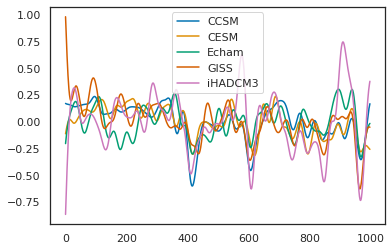

Checking prior for nans
(999,)
Checking prior for nans
(999,)
Checking prior for nans
(999,)
Checking prior for nans
(999,)
Checking prior for nans
Only nans in year 1426-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1427-01-01 00:00:00 . Replaced values with previous year
Only nans in year 1428-01-01 00:00:00 . Replaced values with previous year
(999,)


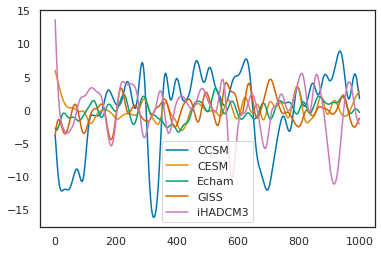

In [73]:
start='0500'
end='2000'
start_a='0800'
end_a='1850'
cutoff=1/50
region=monsoon_region
lw=2

region=monsoon_region
#models
models_tsurf={'CCSM':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
'CESM':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
'Echam':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'GISS':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'iHADCM3':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc'}

models_prec={'CCSM':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'CESM':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'Echam':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'GISS':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'iHADCM3':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc'}

model_data=[]
for m,p in models_tsurf.items():
    data=dataloader.annual_mean(xr.open_dataset(p)['tsurf'],check_nan=True).sel(time=slice('0851','1849'))
    data=quick_filt(regionalmean(anomaly(data,start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
    model_data.append(data)
    plt.plot(data,label=m)
    
plt.legend()
plt.show()
    
model_mean_temp=np.median(model_data,axis=0)
model_std_temp=np.std(model_data,axis=0)

model_data=[]
for m,p in models_prec.items():
    data0=dataloader.annual_mean(xr.open_dataset(p)['prec'],check_nan=True).sel(time=slice('0851','1849'))
    data=quick_filt(regionalmean(anomaly(data0,start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
    model_data.append(data)
    plt.plot(data,label=m)
    print(data.shape)
    
model_mean_prec=np.median(model_data,axis=0)
model_std_prec=np.std(model_data,axis=0)

plt.legend()
plt.show()

time_models=data0.time

## Monsoon region plots:

3 Subplots: Precipitation, Tsurf, Prec-Inf mean (Distance) from 500 to 1999 (anomaly with respect to whole period)

In [9]:
#links to different datasets...
reused='/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc'
noreuse_10='/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/iCESM.nc'

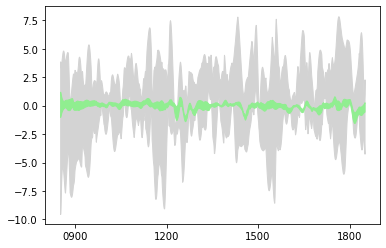

In [39]:
plt.fill_between(time_models.values, model_mean_prec-model_std_prec, model_mean_prec + model_std_prec,color='lightgrey')
plt.fill_between(time_models.values, model_mean_prec_glb-model_std_prec_glb, model_mean_prec_glb + model_std_prec_glb,color='lightgreen')

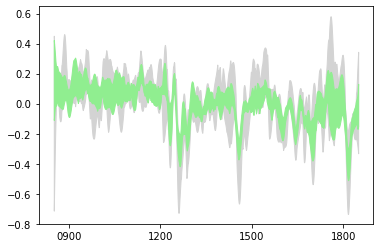

In [40]:
#plt.plot(time_models, y, 'k-')
plt.fill_between(time_models.values, model_mean_temp-model_std_temp, model_mean_temp + model_std_temp,color='lightgrey')
plt.fill_between(time_models.values, model_mean_temp_glb-model_std_temp_glb, model_mean_temp_glb + model_std_temp_glb,color='lightgreen')

(-0.5, 0.75)

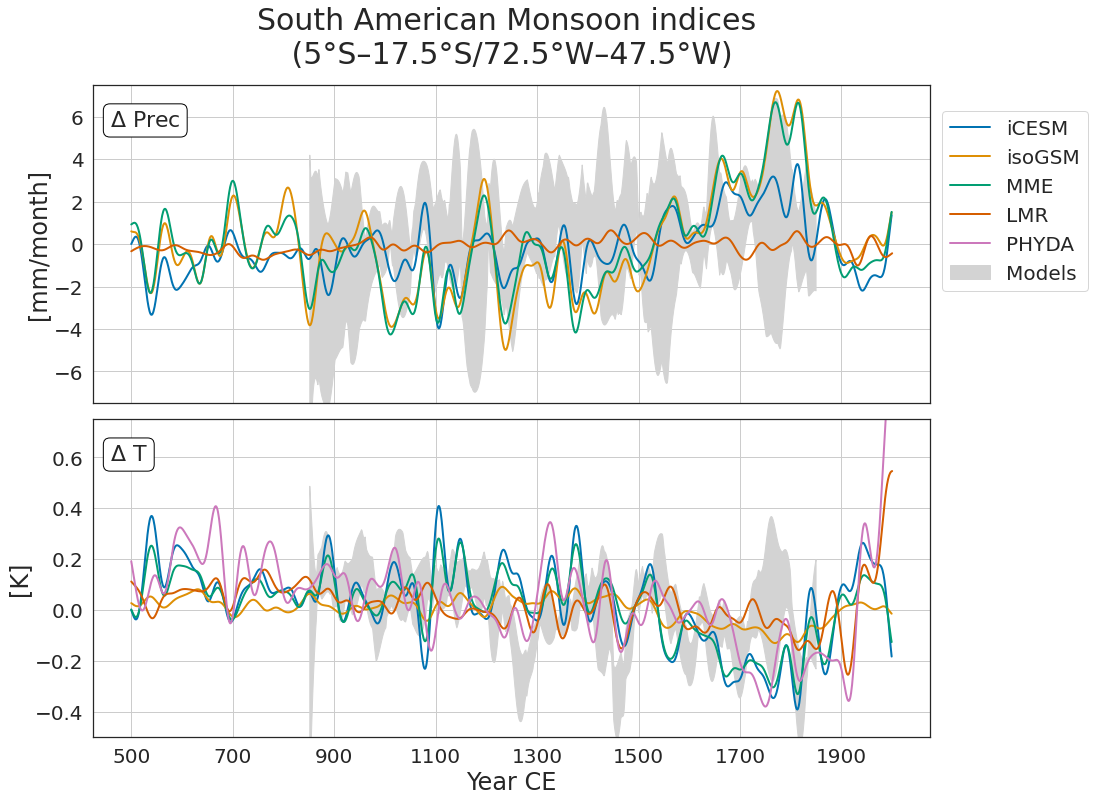

In [181]:
import matplotlib.gridspec as gridspec

fig=plt.figure(figsize = (15,12))
gs1 = gridspec.GridSpec(2, 1)
gs1.update(wspace=0.025, hspace=0.05)

start='0500'
end='2000'
start_a='0800'
end_a='1850'
cutoff=1/50
region=monsoon_region
lw=2

basepath='/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/'
#basepath='/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/'
models=['iCESM','isoGSM','mme_nogiss']

sns.set_palette('colorblind',n_colors=5)

for i,v in enumerate(['prec_mean','tsurf_mean']):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.grid('on')
    
    for m in models:
        path=(basepath+m)+'.nc'
        file=xr.open_dataset(path)[v].sel(time=slice(start,end))
        data=quick_filt(utils.regionalmean(anomaly(file,start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
        if m=='mme_nogiss':
            m='MME'
        #ax1.plot(file.time,data,label=m,lw=lw)
        ax1.plot(data,label=m,lw=lw)
    
    if v=='prec_mean':
        time=lmr_prec.sel(time=slice(start,end)).time
        data=quick_filt(utils.regionalmean(anomaly(lmr_prec.sel(time=slice(start,end)),start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
        #ax1.plot(time,data,label='LMR',lw=lw)
        ax1.plot(data,label='LMR',lw=lw)
        plt.yticks(fontsize=20)
        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
        ax1.text(0.02,0.92,'$\Delta$ Prec', fontsize=22, verticalalignment='top',transform=ax1.transAxes, bbox=props)
        plt.ylabel('[mm/month]',fontsize=24)
        #ax1.fill_between(time_models.values, model_mean_prec-model_std_prec, model_mean_prec + model_std_prec,color='lightgrey')
        ax1.fill_between(np.arange(300+51,300+51+999), model_mean_prec-model_std_prec, model_mean_prec + model_std_prec,color='lightgrey')
        
    elif v=='tsurf_mean':
        time=lmr_tsurf.sel(time=slice(start,end)).time
        data=quick_filt(utils.regionalmean(anomaly(lmr_tsurf.sel(time=slice(start,end)),start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
        #ax1.plot(time,data,label='LMR',lw=lw)
        ax1.plot(data,label='LMR',lw=lw)
        
        time=phyda_tsurf.sel(time=slice(start,end)).time
        data=quick_filt(utils.regionalmean(anomaly(phyda_tsurf.sel(time=slice(start,end)),start=start_a,end=end_a),region[0],region[1]),cutoff=cutoff)
        #ax1.plot(time,data,label='PHYDA',lw=lw)
        ax1.plot(data,label='PHYDA',lw=lw)
        #ax1.fill_between(time_models.values, model_mean_temp-model_std_temp, model_mean_temp + model_std_temp,color='lightgrey',label='Priors')
        ax1.fill_between(np.arange(300+51,300+51+999), model_mean_temp-model_std_temp, model_mean_temp + model_std_temp,color='lightgrey',label='Models')
        
        #ax.fill_between(,prior[1]-prior[2], prior[1]+prior[2],color='lightgrey',label='Models')
        
        plt.yticks(fontsize=20)
        
        props = dict(boxstyle='round', facecolor='white', alpha=1,edgecolor='black')
        ax1.text(0.02,0.92,'$\Delta$ T', fontsize=22, verticalalignment='top',transform=ax1.transAxes, bbox=props)
        plt.ylabel('[K]',fontsize=24)
        
    if i==0:
        #ax1.get_xaxis().set_visible(False)
        #this way we keep the grid
        ax1.get_xaxis().set_ticklabels([])
        plt.title('South American Monsoon indices \n (5°S–17.5°S/72.5°W–47.5°W) ',fontsize=30,y=1.05)
        ax=plt.gca()
        ax.set_ylim(-7.5,7.5)
        
#import matplotlib.dates as md
#ax=plt.gca()
#step = 200
#ax.xaxis.set_major_locator(md.YearLocator(step, month = 1, day = 1))
#ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))

plt.legend(fontsize=20,bbox_to_anchor=(1.2, 2))#loc='lower left')
plt.xticks(fontsize=20)
plt.xlabel('Year CE',fontsize=24)
labels=np.arange(300,2200,200)
ax=plt.gca()
ax.set_xticklabels(labels)
ax.set_ylim(-0.5,0.75)



In [182]:
fig.savefig('/home/mchoblet/plots_thesis/6_2/monsoon_index.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

In [208]:
pip install Wand

     |████████████████████████████████| 142 kB 4.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


# Map plots, from 5th to 20th century

In [197]:
def regional_plot(data_0=None,path=None,var=None,ano=True,bounds=[[30,80],[310,60]],title='Temperature',anomaly_period=['1850','1900'],freq=100,start_y='0800',end_y='1999',vmax=10,vmin=-10,
                     cmap='RdBu_r', #BrBG_r for precipitation
                    figsize=(20,15),
                    size=100,
                    label=r'$\Delta$T [K]',
                    plotbox=None,maskocean=False,
                    proxies=proxies,
                    invert=False,
                    ):
    
    start=anomaly_period[0]
    end=anomaly_period[1]
        
    if data_0 is None:
        data_org=xr.open_dataset(path)
        data_0=data_org[var]

    data_0=data_0.sel(time=slice(start_y,end_y))

    data=data_0-data_0.sel(time=slice(start,end)).mean('time')
    data=data.resample(time=(str(freq)+'YS'),label='left').mean('time')

    #cut fields
    lat=data.lat
    lon=data.lon
    lats,lons=bounds[0],bounds[1]
    if lons[0]<lons[1]:    #selection of longitudes
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon = lon.where( (lon >= lons[0] ) & (lon <= lons[1]), drop=True)
    else:    #cross zero-meridian region option
        sel_lat = lat.where( (lat >= lats[0] ) & (lat <= lats[1]), drop=True)
        sel_lon_1 = lon.where( (lon >= lons[0] ), drop=True)
        sel_lon_2 = lon.where((lon <= lons[1]), drop=True)
        sel_lon=xr.concat([sel_lon_1,sel_lon_2],dim='lon')
    data_cut=data.sel(lat=sel_lat,lon=sel_lon)
    
    if proxies!=None:
        proxy_ano=[]
        for p in proxies:
            #compute anomaly period
            p=xr.open_dataset(p)['d18O'].sel(time=slice(start_y,end_y))
            p=p-p.sel(time=slice(anomaly_period[0],anomaly_period[1])).mean('time')
            p=p.resample(time=(str(freq)+'YS'),label='left').mean('time')
            proxy_ano.append(p)
            #proxies_lat=data_org['proxies_lat']
            #proxies_lon=data_org['proxies_lon']
            #proxies['lat']=proxies_lat
            #proxies['lon']=proxies_lon
        proxies=proxy_ano
    
    sns.set_theme(style="white")

    figsize=figsize
    
    timelen=len(data.time)
    
    ncols=4
    nrows=np.ceil(timelen/ncols).astype('int')
    
    fig, axes = plt.subplots(ncols=ncols,nrows=nrows,figsize=figsize,subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=40)

    for i,t in enumerate(data_cut.time):
        ax=axes.flatten()[i]
        
        if plotbox==True:
            ax.plot([285.5,312.5,312.5,285.5,285.5],[-17.5,-17.5,-5,-5,-17.5], transform=ccrs.PlateCarree(),color='blue')
            
        
        if maskocean==True:
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='white'))
        
        ax.add_feature(cfeature.COASTLINE)
        ax.axes.gridlines(color='black',alpha=0.5,linestyle='--')

        ax.axes.xaxis.set_visible(True)
        ax.axes.yaxis.set_visible(True)
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

        plot=data_cut.sel(time=t).plot(vmax=vmax,vmin=vmin,ax=ax,cmap=cmap,add_colorbar=False)

        year=data_cut.time.dt.year[i].values     
        
        #plot proxy values as scatter points
        """
        if proxies_ano==True:
            prox_i=proxies[i].dropna('site')
            scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
            string=str(year)+'-'+str(year+freq)+' ['+str(np.round(np.min(prox_i.values),1))+','+str(np.round(np.max(prox_i.values),1))+']'
        else:
            string=str(year)+'-'+str(year+freq)
        """    
        ax.set_ylabel('',fontsize=30,rotation=0)
        ax.set_xlabel('',fontsize=30,rotation=0)
        string=str(year)+'-'+str(year+freq)
        ax.set_title(string,fontsize=25)
        
        
        if proxies!=None:
            for p in proxies:
                prox_i=p[i].dropna('site')
                #if invert:
                scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG_r', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
                #else:
                #    scatter=ax.scatter(prox_i['lon'],prox_i['lat'],c=prox_i,s=size, cmap='PiYG_', transform=ccrs.PlateCarree(), edgecolors='black',vmin=-2,vmax=2)
        
        #ax=plt.gca()
        

            #ax.relim()
            #ax.autoscale_view()
            """
            plotbox=[[-17.5,-5],[287.5,312.5]]
            width=np.abs(plotbox[1][1]-plotbox[1][0])
            height=np.abs(plotbox[0][0]-plotbox[0][1])
            
            xy=[plotbox[1][0],plotbox[0][0]]
            rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                                    facecolor=None,
                                    edgecolor='blue',                                
                                    transform=ccrs.PlateCarree(),fill=False,clip_on=False)
            axes.flatten()[5].add_patch(rectangle)
            #ax.relim()
            #ax.autoscale_view()
            """
        #land-sea-mask
        
    
    #delete last one
    fig.delaxes(axes[-1][-1])
            
    
    """

    plotbox=[[-17.5,-5],[287.5,312.5]]
    width=np.abs(plotbox[1][1]-plotbox[1][0])
    height=np.abs(plotbox[0][0]-plotbox[0][1])

    xy=[plotbox[1][0],plotbox[0][0]]
    rectangle=mpatches.Rectangle(xy=xy, width=width, height=height,
                            facecolor=None,
                            edgecolor='blue',                                
                            transform=ccrs.PlateCarree(),fill=False)
    axes.flatten()[0].add_patch(rectangle)
    """
    
    #p0=axes.flatten()[-3].get_position().get_points().flatten()
    p0=axes.flatten()[-4].get_position().get_points().flatten()
    p2=axes.flatten()[-1].get_position().get_points().flatten()

    from matplotlib import ticker

    #colormap variable
    ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.05, (p2[2]-p0[0]), 0.02])
    cb=fig.colorbar(plot, cax=ax_cbar1, orientation='horizontal',cmap=cmap)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label(label,fontsize=30)
    
    if proxies!=None:
        #colormap for d18O
        ax_cbar1 = fig.add_axes([p0[0], p0[1]-0.15, (p2[2]-p0[0]), 0.02])
        cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal')
        #else:
        #    cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal',cmap='PiYG')
        #cb=fig.colorbar(scatter, cax=ax_cbar1, orientation='horizontal',cmap='BrBG')
        cb.ax.tick_params(labelsize=20)
        tick_locator = ticker.MaxNLocator(nbins=6)
        cb.locator = tick_locator
        cb.update_ticks()
        cb.set_label(u'Proxy record $\Delta(\delta^{18}$O) [‰]',fontsize=30)
        if invert:
            cb.ax.invert_xaxis()
        
    return fig
    
    

In [82]:
proxies=['/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_az_10.nc','/home/mchoblet/paleoda/data/proxy_dbs/sisal_1700_1800_ma.nc','/home/mchoblet/paleoda/data/proxy_dbs/quelcaya_az.nc']

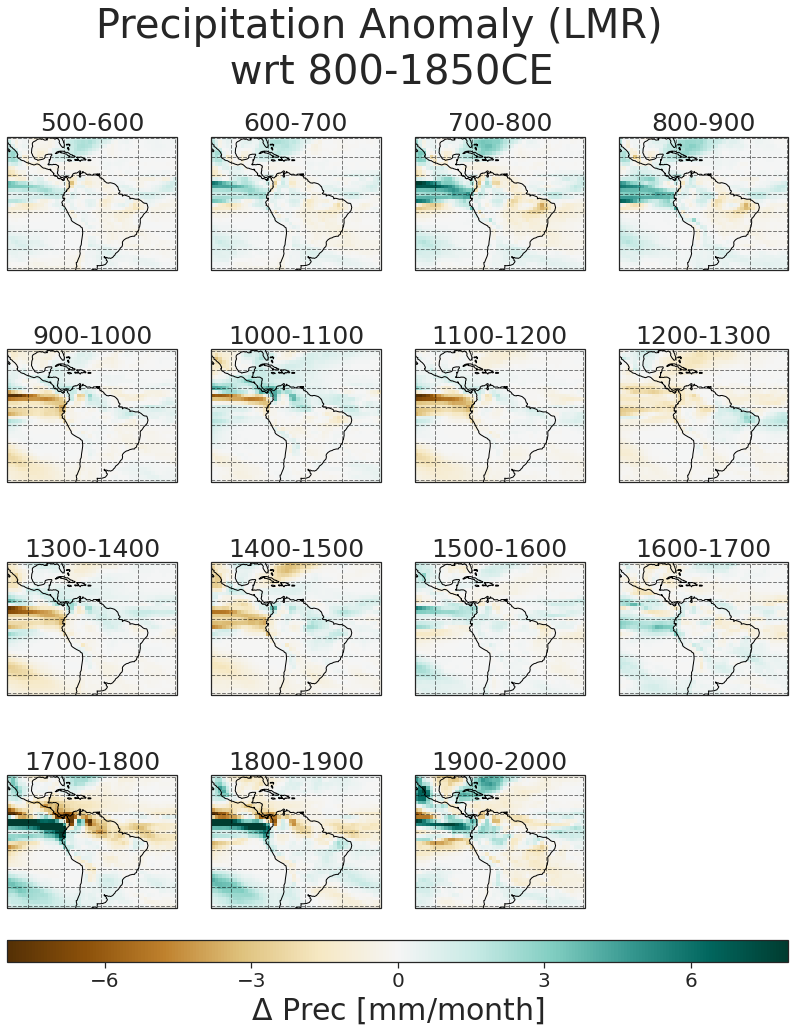

In [183]:
region_prec_lmr=regional_plot(lmr_prec,
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc')['tsurf_mean'],
              vmax=8,vmin=-8,
              title='Precipitation Anomaly (LMR) \n wrt 800-1850CE', 
              bounds=[[-40,30],[250,340]],
              #cmap='RdBu_r',
              cmap='BrBG',
              label=r'$\Delta$ Prec [mm/month]',
              #label=r'$\Delta$ T',
              figsize=(14,15),
              start_y='0500',
              #anomaly_period=['1700','1800'],
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              #proxies=proxies,
              proxies=None,
              size=80,
              #proxies=None,
              plotbox=False,
              maskocean=False)

In [184]:
region_prec_lmr.savefig('/home/mchoblet/plots_thesis/6_2/lmr_prec.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

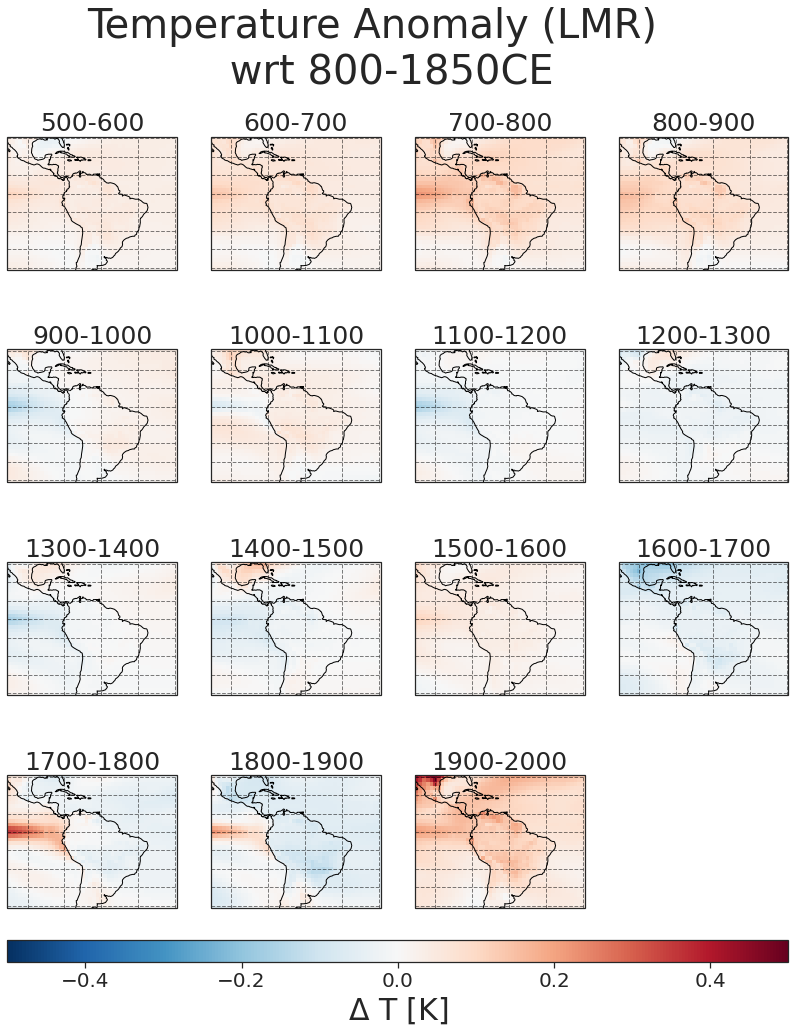

In [185]:
region_tsurf_lmr=regional_plot(lmr_tsurf,
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc')['tsurf_mean'],
              vmax=0.5,vmin=-0.5,
              title='Temperature Anomaly (LMR)  \n wrt 800-1850CE', 
              bounds=[[-40,30],[250,340]],
              cmap='RdBu_r',
              #cmap='BrBG',
              label=r'$\Delta$ T [K]',
              #label=r'$\Delta$ T',
              figsize=(14,15),plotbox=False,
              start_y='0500',
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              proxies=None,
              size=80,
              #proxies=None,
             maskocean=False)

In [186]:
region_tsurf_lmr.savefig('/home/mchoblet/plots_thesis/6_2/lmr_tsurf.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

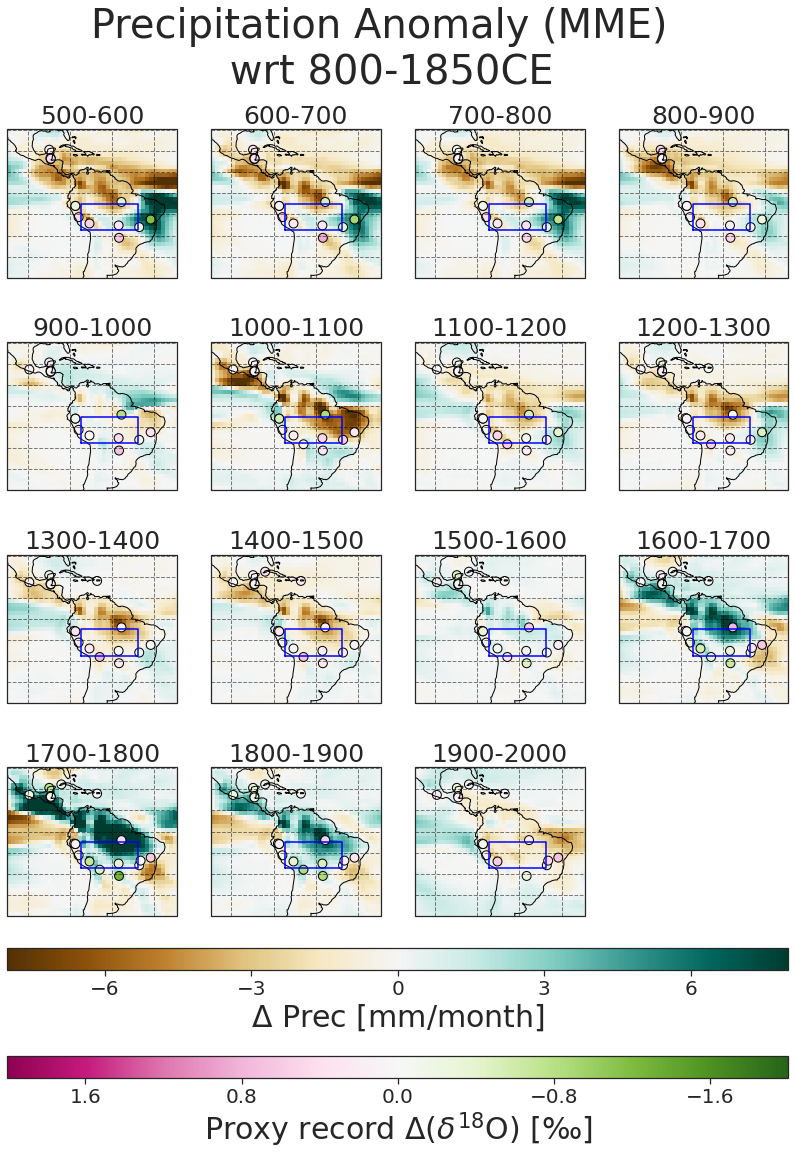

In [198]:
region_prec=regional_plot(
              xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/mme_nogiss.nc')['prec_mean'],
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/GISS.nc')['prec_mean'],
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc')['prec_mean'],
              vmax=8,vmin=-8,
              title='Precipitation Anomaly (MME) \n wrt 800-1850CE', 
              bounds=[[-40,30],[250,340]],
              #cmap='RdBu_r',
              cmap='BrBG',
              label=r'$\Delta$ Prec [mm/month]',
              #label=r'$\Delta$ T',
              figsize=(14,15),
              start_y='0500',
              #anomaly_period=['1700','1800'],
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              proxies=proxies,
              size=80,
              #proxies=None,
              plotbox=True,
              invert=True,
              maskocean=False)

In [199]:
region_prec.savefig('/home/mchoblet/plots_thesis/6_2/mme_prec.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

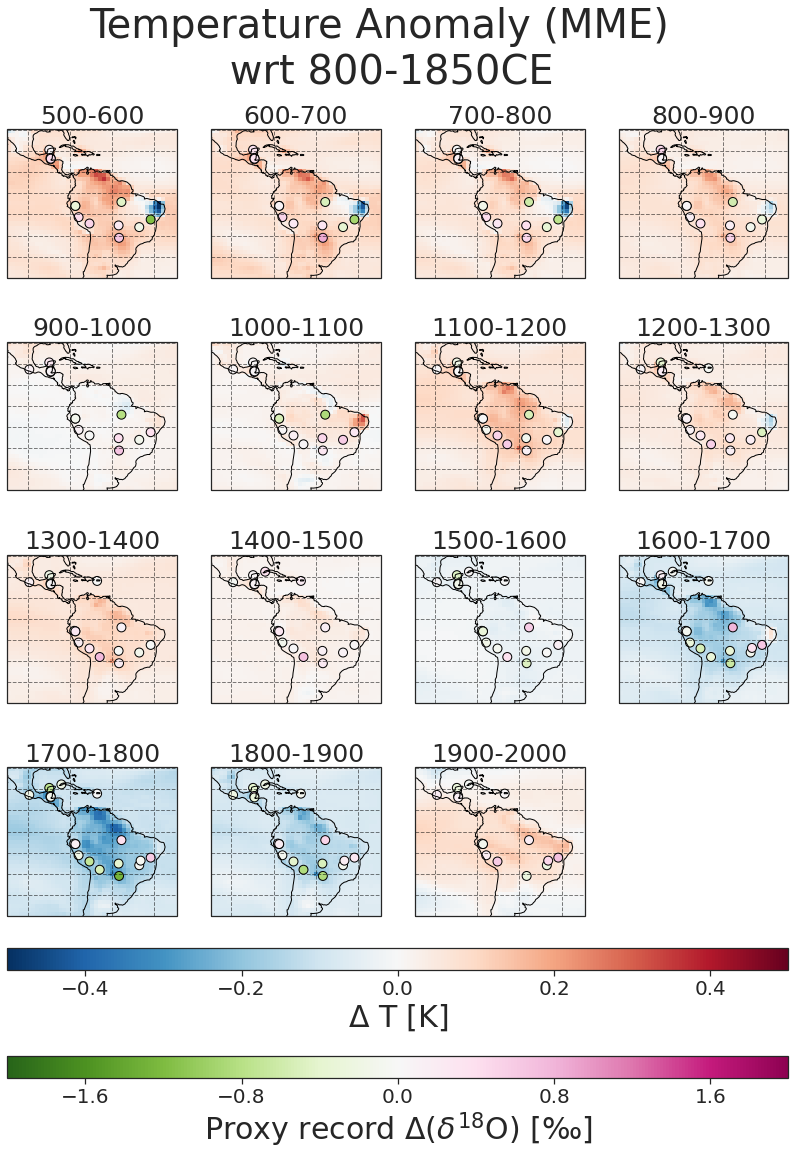

In [200]:
region_tsurf=regional_plot(
              xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/mme_nogiss.nc')['tsurf_mean'],
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/Echam.nc')['tsurf_mean'],
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc')['tsurf_mean'],
              vmax=0.5,vmin=-0.5,
              title='Temperature Anomaly (MME) \n wrt 800-1850CE', 
              bounds=[[-40,30],[250,340]],
              cmap='RdBu_r',
              #cmap='BrBG',
              label=r'$\Delta$ T [K]',
              #label=r'$\Delta$ T',
              figsize=(14,15),plotbox=False,
              start_y='0500',
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              proxies=proxies,
              size=80,
              #proxies=None,
             invert=False,
             maskocean=False)

In [201]:
region_tsurf.savefig('/home/mchoblet/plots_thesis/6_2/mme_tsurf.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )

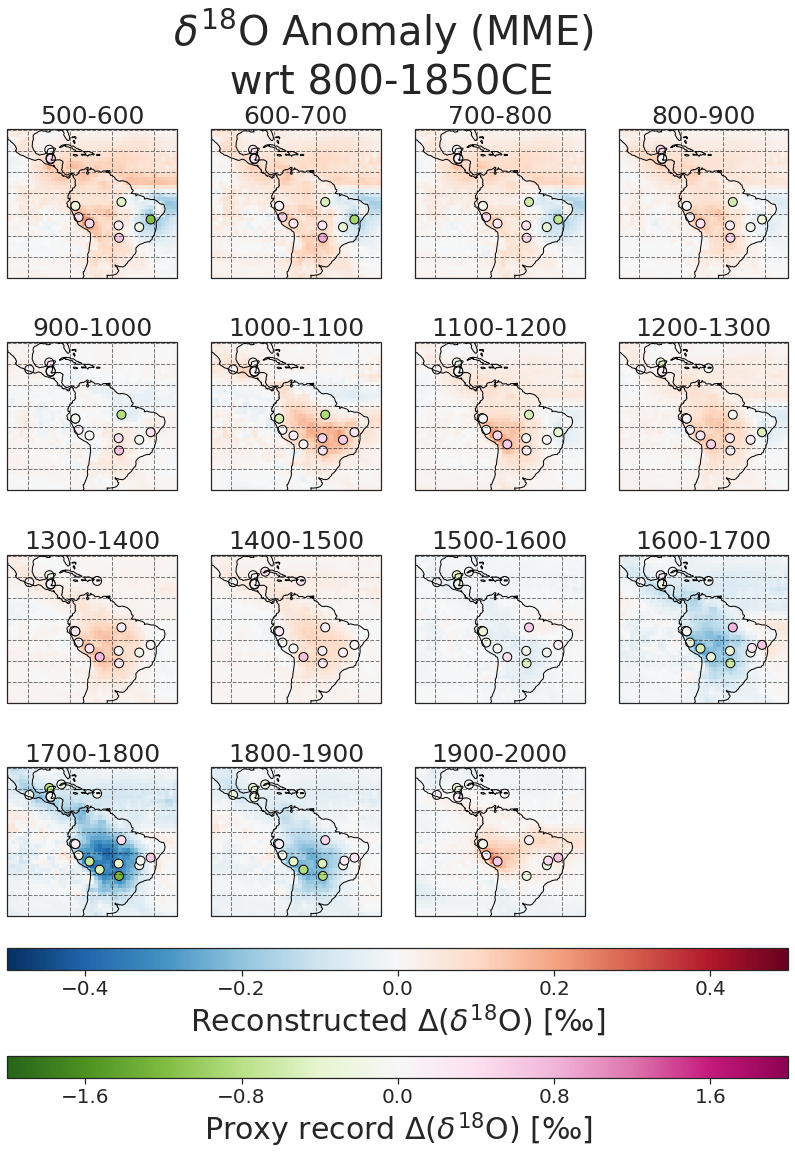

In [202]:
region_d18O=regional_plot(xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_10year_noreuse/mme_nogiss.nc')['d18O_mean'],
              #xr.open_dataset('/home/mchoblet/paleoda/results/experiments/thesis_6_2_regular/iCESM.nc')['tsurf_mean'],
              vmax=0.5,vmin=-0.5,
              title='$\delta^{18}$O Anomaly (MME) \n wrt 800-1850CE', 
              bounds=[[-40,30],[250,340]],
              cmap='RdBu_r',
              #cmap='BrBG',
              label=r'Reconstructed $\Delta$($\delta^{18}$O) [‰]',
              #label=r'$\Delta$ T',
              figsize=(14,15),plotbox=False,
              start_y='0500',
              anomaly_period=['0800','1850'],
              #anomaly_period=['1700','1800'],
              proxies=proxies,
              size=80,
              #proxies=None,
             invert=False,
             maskocean=False)

In [203]:
region_d18O.savefig('/home/mchoblet/plots_thesis/6_2/mme_d18O.pdf', dpi='figure', format='pdf', metadata=None,
        bbox_inches='tight', pad_inches=0.1,
        facecolor='auto', edgecolor='auto',
        backend=None,
       )